In [1]:
import torch
from torch import nn
import gym

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from collections import deque

In [2]:
env_id = 'CartPole-v1'
env_id = 'CartPole-v0'
env = gym.make(env_id)
n_actions = env.action_space.n
len_obs_space = env.observation_space.shape[0]

print('n_actions = {}'.format(n_actions))
print('len_obs_space = {}'.format(len_obs_space))
# torch.manual_seed(1423)
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_actions = 2
len_obs_space = 4


https://gsurma.medium.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288#:~:text=Cartpole%20%2D%20known%20also%20as%20an,forces%20to%20a%20pivot%20point.


https://github.com/gsurma/cartpole

In [3]:
class DQN(nn.Module):

    def __init__(self, lr, device) -> None:
        super().__init__()
        torch.manual_seed(1423)
        hidden_layer_size = 64
        # self.flatten = nn.Flatten()
        # self.seq_relu = nn.Sequential(
        #     nn.Linear(len_obs_space, hidden_layer_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_layer_size, hidden_layer_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_layer_size, n_actions)
        # )
        # self.seq_relu = nn.Sequential(
        #     nn.Linear(len_obs_space, hidden_layer_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_layer_size, n_actions),
        # # )
        self.seq = nn.Sequential(
            nn.Linear(len_obs_space, hidden_layer_size),
            nn.Tanh(),
            nn.Linear(hidden_layer_size, n_actions),
            nn.Identity()
        )
        # nn.Linear(len_obs_space, hidden_layer_size)
        # nn.Tanh()
        # nn.Linear(hidden_layer_size, n_actions)
        # nn.Identity()

        self.learning_rate = lr
        self.device = device

        # self.optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        # self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # # self.optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        # self.loss = nn.MSELoss()

    
    def forward(self, x):
        # x = self.flatten(x)
        logits = self.seq(x)
        return logits


# learning_rate = 0.05
# q_approx = DQN(lr=learning_rate, device=device).to(device)
# q_target = DQN(lr=learning_rate, device=device).to(device)
# # load same weights as approx
# q_target.load_state_dict(q_approx.state_dict())
# q_target.eval()
# print(q_approx)
# print(q_target)


In [4]:
import random
import copy
import time
class Agent:
    '''
        https://blog.gofynd.com/building-a-deep-q-network-in-pytorch-fa1086aa5435
    '''    
    def __init__(self, q_model, env, epsilon, gamma, batch_size, exp_mem_size, lr) -> None:
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(1423)
        # torch.manual_seed(int(time.time()))
        # torch.seed()
        input_dim = env.observation_space.shape[0]
        output_dim = env.action_space.n

        # self.my_model = q_model
        # self.q_model = self.build_nn([input_dim, 64, output_dim])

        # self.my_model.load_state_dict(self.q_model.state_dict())

        # print('My model params')        
        # for index in range(len(self.my_model.state_dict())):
        #     # print(param)
        #     self.my_model.parameters()[index] =   self.q_model.parameters()[index]

        # self.my_model.state_dict()['seq.0.weight'] = self.q_model.state_dict()['0.weight']
        # print('Their model params')        
        # print(self.q_model.state_dict()['0.weight'])
        # for param in self.q_model.parameters():
        #     print()

        # print('My model params')        
        # print(self.my_model.state_dict()['seq.0.weight'])
        # for param in self.my_model.parameters():
        #     print(param)        

        # print('my_model = {}'.format(self.my_model))
        # print('their model = {}'.format(self.q_model))

        # load same weights as approx
        # self.q_target = copy.deepcopy(self.q_model)
        # self.q_target = self.build_nn([input_dim, 64, output_dim])

        self.q_model = q_model
        self.q_target = DQN(learning_rate, device=device)
        self.q_target.load_state_dict(self.q_model.state_dict())
        self.q_target.eval()
        
        self.env = env
        self.n_actions = self.env.action_space.n
        self.epsilon = epsilon
        # self.device = self.q_model.device
        # self.gamma = gamma
        self.gamma = torch.tensor(gamma).float()
        self.steps_done = 0
        self.train_data = []

        self.target_update = 5
        self.target_update_counter = 0
        self.train_step_count = 0

        self.EXP_MEMORY_SIZE = exp_mem_size
        self.BATCH_SIZE = batch_size

        self.D = deque(maxlen=self.EXP_MEMORY_SIZE)
        # self.clear_replay_memory()

        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=lr)
        # self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=self.q_model.learning_rate)
        # self.optimizer = torch.optim.SGD(self.q_model.parameters(), lr=self.q_model.learning_rate)


    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        layers = []
        for index in range(len(layer_sizes) - 1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index + 1])
            act = nn.Tanh() if index < len(layer_sizes) - 2 else nn.Identity()
            # act = nn.ReLU() if index < len(layer_sizes) - 2 else nn.Identity()
            layers += (linear, act)
        return nn.Sequential(*layers)

    def init_replay_memory(self):
        """
            initialise replay memory
        """
        self.clear_replay_memory()
        is_mem_filled = False
        counter = 0
        for _ in range(self.EXP_MEMORY_SIZE):
            # if is_mem_filled:
            #     break
            done = False
            obs = self.env.reset()
            # obs = torch.tensor([obs], device=self.device, dtype=torch.float64)
            while not done:
                # get action to execute based on state
                action = self.get_action(obs, self.n_actions, epsilon=1)
                
                #  take action, go to next time step
                obs_next, reward, done, info = self.env.step(action.item())
                self.collect_experience([obs, action.item(), reward, obs_next, done])

                # create transition
                # transition = [obs, action, reward, obs_next, done]
                # store transition
                # self.D.append(transition)

                obs = obs_next
                counter += 1
                if counter > self.EXP_MEMORY_SIZE:
                    break
                # is_mem_filled = True if counter > self.EXP_MEMORY_SIZE else False
                # if is_mem_filled:
                #     break
        

    def clear_replay_memory(self):
        """[summary]
            
            clear experience reply memory
        """ 
        self.D = deque(maxlen=self.EXP_MEMORY_SIZE)

    
    def get_target_q_vals(self, obs):
        '''
            Return the target q-values for given observation

            obs: torch shape(n_samples, n_features)
        '''
        # vals = None
        # with torch.no_grad():
        #     vals = self.q_target(obs.float()).amax(dim=1)

        # return vals
        with torch.no_grad():
            qp = self.q_target(obs)
        q, _ = torch.max(qp, axis=1)
        return q

    def train_episode(self):
        done = False
        obs = self.env.reset()
        obs = torch.tensor([obs], device=self.device, dtype=torch.float64)
        rewards = []
        # frame_count = 0
        # target_frame_update = 5
        while not done:
            # get action to execute based on state
            action = self.get_action(obs.float())
            #  take action, go to next time step
            obs_next, reward, done, info = self.env.step(action.item())
            rewards.append(reward)
            # convert to tensors
            obs_next = torch.tensor([obs_next], device=self.device, dtype=torch.float64)
            reward = torch.tensor([reward,], device=self.device).reshape((-1,1))
            # print(reward.shape)
            done = torch.tensor(done, device=self.device, dtype=torch.bool)
            
            # create transitions
            # transition = (obs, action, reward, obs_next, done)
            # store transitions
            # self.D.append(transition)
            self.collect_experience([obs, action.item(), reward, obs_next, done])

            self.train_step_count += 1

            obs = obs_next

            if self.train_step_count > 128:
                # print('gf')
                self.train_step_count = 0
                for _ in range(4):
                    # update target
                    if self.target_update_counter == self.target_update:
                        self.q_target.load_state_dict(self.q_model.state_dict())
                        self.q_target.eval()
                        self.target_update_counter = 0                        

                    # sample minibatch
                    # mini_batch = random.choices(self.D, k=self.BATCH_SIZE)
                    mini_batch = random.sample(self.D, k=self.BATCH_SIZE)

                    obs_batch = tuple([tple[0] for tple in mini_batch])
                    # print('obsss')
                    # print(' obs_batch = {}'.format(obs_batch))
                    obs_batch = torch.cat(obs_batch, dim=0)
                    # print('obs_batch = {}'.format(obs_batch.shape))

                    action_batch = tuple([tple[1] for tple in mini_batch])
                    # action_batch = torch.cat(action_batch, dim=0).reshape(-1,1)
                    action_batch = torch.cat(action_batch, dim=0)
                    # print('action_batch = \n{}'.format(action_batch.shape))

                    reward_batch = torch.tensor([tple[2] for tple in mini_batch])
                    # reward_batch = reward_batch.reshape((-1,1))
                    # print('reward_batch = \n{}'.format(reward_batch.shape))

                    obs_next_batch = tuple([tple[3] for tple in mini_batch])
                    obs_next_batch = torch.cat(obs_next_batch, dim=0)
                    # print('obs_next_batch = \n{}'.format(obs_next_batch.shape))
                
                    done_batch = torch.tensor([tple[4] for tple in mini_batch])
                    # done_batch = reward_batch.reshape((-1,1))
                    # print('done_batch = \n{}'.format(done_batch.int()))

                    # print(action)
                    # Compute prediction and loss
                    # q_values = self.q_model(obs_batch.float()).gather(1, action_batch)
                    q_values = self.q_model(obs_batch.float())
                    # pred = q_values[torch.arange(16), action_batch]
                    pred, _ = torch.max(q_values, axis=1)
                    # target_q_values  = self.q_target(obs_batch.float())
                    target_q_values = self.get_target_q_vals(obs_batch.float())
                    # print('target_q_values = {}'.format(target_q_values.shape))
                    # y = reward_batch + self.gamma*torch.max(target_q_values)*(1-done_batch.int())
                    y = reward_batch + self.gamma*torch.max(target_q_values)
                    # loss = self.q_model.loss(q_values, y)
                    loss = self.q_model.loss(pred, y)
                    
                    
                    
                    # Backpropagation
                    self.q_model.optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    self.q_model.optimizer.step()
                    # self.optimizer.zero_grad()
                    # loss.backward(retain_graph=True)
                    # self.optimizer.step()

                    self.target_update_counter += 1
                    # print('-'*5)
                    # print('obs_batch = {}'.format(obs_batch.shape))
                    # print('action_batch = {}'.format(action_batch.shape))
                    # print('reward_batch = {}'.format(reward_batch.shape))
                    # print('obs_next_batch = {}'.format(obs_next_batch.shape))
                    # print('q_values = {}'.format(q_values.shape))
                    # print('pred = {}'.format(pred.shape))
                    # print('target_q_values = {}'.format(target_q_values.shape))
                    # print('y = {}'.format(y.shape))
                    # print('loss = {}'.format(loss))
                    # print('-'*5)

        rewards = np.array(rewards)
        self.train_data.append(np.sum(rewards))
    
    def sample_experience(self, sample_size):
        # sample_size = self.BATCH_SIZE
        if len(self.D) < sample_size:
            sample_size = len(self.D)

        mini_batch = random.sample(self.D, sample_size)

        obs_batch = torch.tensor([tple[0] for tple in mini_batch]).float()
        action_batch = torch.tensor([tple[1] for tple in mini_batch]).float()
        reward_batch = torch.tensor([tple[2] for tple in mini_batch]).float()
        obs_next_batch = torch.tensor([tple[3] for tple in mini_batch]).float()
        done_batch = torch.tensor([tple[4] for tple in mini_batch])

        # print('-'*5)
        # print('obs_batch = {}'.format(obs_batch.shape))
        # print('action_batch = {}'.format(action_batch.shape))
        # print('reward_batch = {}'.format(reward_batch.shape))
        # print('obs_next_batch = {}'.format(obs_next_batch.shape))
        # print('-'*5)
        return obs_batch, action_batch, reward_batch, obs_next_batch, done_batch
        

    def train(self, batch_size):
        # sample minibatch
        obs_batch, action_batch, reward_batch, obs_next_batch, done_batch = self.sample_experience(batch_size)
        
        if self.target_update_counter == self.target_update:
            self.q_target.load_state_dict(self.q_model.state_dict())
            self.q_target.eval()
            self.target_update_counter = 0                        

        # Compute prediction and loss
        q_values = self.q_model(obs_batch)
        pred, _ = torch.max(q_values, axis=1)
        target_q_values = self.get_target_q_vals(obs_next_batch)
        # y = reward_batch + self.gamma*torch.max(target_q_values)*(1-done_batch.int())
        # y = reward_batch + self.gamma*torch.max(target_q_values)
        y = reward_batch + self.gamma*target_q_values

        # loss = self.q_model.loss(pred, y)
        loss = self.loss(pred, y)
        
        
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        self.optimizer.step()

        self.target_update_counter += 1

        # print('-'*5)
        # print('obs_batch = {}'.format(obs_batch.shape))
        # print('action_batch = {}'.format(action_batch.shape))
        # print('reward_batch = {}'.format(reward_batch.shape))
        # print('obs_next_batch = {}'.format(obs_next_batch.shape))
        # print('q_values = {}'.format(q_values.shape))
        # print('pred = {}'.format(pred.shape))
        # print('target_q_values = {}'.format(target_q_values.shape))
        # print('y = {}'.format(y.shape))
        # print('loss = {}'.format(loss))
        # print('-'*5)
        return loss.item()

    def get_action(self, state, action_space_len, epsilon):
        # We do not require gradient at this point, because this function will be used either
        # during experience collection or during inference
        with torch.no_grad():
            # Qp = self.q_net(torch.from_numpy(state).float().cuda())
            state_torch = torch.from_numpy(state)
            # print(state_torch)
            Qp = self.q_model(state_torch.float())
            # print(Qp)
        Q, A = torch.max(Qp, axis=0)
        # print('Q, A = {}, {}'.format(Q, A))
        A = A if torch.rand(1, ).item() > epsilon else torch.randint(0, action_space_len, (1,))
        return A

    def collect_experience(self, experience):
        self.D.append(experience)
        

    # def get_action(self, obs):
    #     # sample = random.random()
    #     action = None
    #     # if sample < self.epsilon:
    #     #     action = torch.tensor([random.choice(range(self.n_actions))])
    #     # else:
    #     #     with torch.no_grad():
    #     #         # print(obs)
    #     #         state_torch = torch.from_numpy(obs).float()
    #     #         q_vals = self.q_model(state_torch)
    #     #         # print(q_vals)
    #     #         action = torch.argmax(q_vals)
    #     with torch.no_grad():
    #         # print(obs)
    #         state_torch = torch.from_numpy(obs).float()
    #         q_vals = self.q_model(state_torch)
    #         # print(q_vals)
    #         action = torch.argmax(q_vals)
        
    #     action = torch.tensor([action], device=self.device)
    #     action = action if torch.rand(1, ).item() > epsilon else torch.randint(0, self.n_actions, (1,))

    #     # print(action.item())
    #     return action


In [5]:
# -------------------------------
# hyperparameters
TARGET_UPDATE = 10

EPSILON_MIN = 0.05
EPSILON_START = 1
EPS_DECAY = 0.001
# EPS_DECAY = 0.0099

epsilon = EPSILON_START
gamma = 0.999
EPISODES = 10000

MINI_BATCH_SIZE = 16
MEMORY_SIZE = 256
# MINI_BATCH_SIZE = 10
# MEMORY_SIZE = 100
# -------------------------------

We need to tune the hyperparams
- epsilon (epsilong_min)
- gamma (discount rate)
- learning rate
- target update
- mini batch size

In [6]:
# create range for hyperparams
# learning_rates = np.arange(0.0001, 0.0002, 0.00001)
# gammas = np.arange(0.98, 1.001, 0.001)
gammas = np.array([0.95])
learning_rates = np.array([1e-3])

print('lr.shape = {}'.format(learning_rates.shape))
print('gammas.shape = {}'.format(gammas.shape))

lr.shape = (1,)
gammas.shape = (1,)


In [7]:
rewards = np.zeros((len(learning_rates), len(gammas), EPISODES))

In [8]:
print(rewards.shape)



(1, 1, 10000)


In [9]:
BASE_PATH = "./dqn_models/"
'''
for index_lr, learning_rate in enumerate(learning_rates):
    print('-'*5)
    print('lr = {}'.format(learning_rate))
    for index_gamma, gamma in enumerate(gammas):
        q_approx = DQN(lr=learning_rate, device=device).to(device)
        q_target = DQN(lr=learning_rate, device=device).to(device)
        # load same weights as approx
        q_target.load_state_dict(q_approx.state_dict())
        q_target.eval()

        # print(q_approx)
        # print(q_target)
        # print(index_gamma)
        
        agent = Agent(q_approx, q_target, env, epsilon, gamma, MINI_BATCH_SIZE, MEMORY_SIZE)

        # reset replay memory
        agent.init_replay_memory()

        for episode in range(EPISODES):

            # if episode % 100 == 0:
            #     print('Episode = {}'.format(episode))
            #     print('Epsilon = {}'.format(agent.epsilon))
            # train one episode
            agent.train_episode()

            # update epsilon value
            # agent.epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN)*np.exp(-EPS_DECAY*episode)
            if agent.epsilon > 0.05:
                agent.epsilon -= (1 / 5000)

            # update target paramters
            # if episode % TARGET_UPDATE == 0:
            #     q_target.load_state_dict(q_approx.state_dict())
            #     q_target.eval()
        
        # shallow copy
        # rewards_per_episode = agent.train_data.copy()
        # alias
        rewards_per_episode = agent.train_data
        rewards[index_lr, index_gamma] = rewards_per_episode 

        total_rewards = np.sum(rewards[index_lr, index_gamma,:])
        print("Score over time: {}, gamma={}".format(total_rewards/EPISODES, gamma))
        average_reward = total_rewards/EPISODES

        # save models
        model_info = str(learning_rate)+ '_' + str(gamma)
        path = BASE_PATH + 'model' + '_' + model_info + '.pt'
        q_name = 'q_approx_state_dict_' + model_info
        optim_name = 'optim_state_dict_' + model_info
        model = {
            q_name: agent.q_model.state_dict(),
            optim_name: agent.q_model.optimizer.state_dict()
        }
        # model = {
        #     q_name: agent.q_model.state_dict(),
        #     optim_name: agent.optimizer.state_dict()
        # }
        torch.save(model, path)
    print('-'*5)
# save rewards to disk
with open("./dqn_rewards/dqn_rewards.pkl",'wb') as f:
    pickle.dump(rewards, f)
'''

'\nfor index_lr, learning_rate in enumerate(learning_rates):\n    print(\'-\'*5)\n    print(\'lr = {}\'.format(learning_rate))\n    for index_gamma, gamma in enumerate(gammas):\n        q_approx = DQN(lr=learning_rate, device=device).to(device)\n        q_target = DQN(lr=learning_rate, device=device).to(device)\n        # load same weights as approx\n        q_target.load_state_dict(q_approx.state_dict())\n        q_target.eval()\n\n        # print(q_approx)\n        # print(q_target)\n        # print(index_gamma)\n        \n        agent = Agent(q_approx, q_target, env, epsilon, gamma, MINI_BATCH_SIZE, MEMORY_SIZE)\n\n        # reset replay memory\n        agent.init_replay_memory()\n\n        for episode in range(EPISODES):\n\n            # if episode % 100 == 0:\n            #     print(\'Episode = {}\'.format(episode))\n            #     print(\'Epsilon = {}\'.format(agent.epsilon))\n            # train one episode\n            agent.train_episode()\n\n            # update epsilon 

In [10]:
'''
# plot average reward data
# print(rewards[:,:,:].shape)
import pandas as pd

d = pd.Series(rewards[0,0,:])
plt.plot(np.arange(EPISODES),d.rolling(100).mean())
plt.xlabel('episodes')
plt.ylabel('average reward')
# plt.plot(rewards[:,:])
'''

"\n# plot average reward data\n# print(rewards[:,:,:].shape)\nimport pandas as pd\n\nd = pd.Series(rewards[0,0,:])\nplt.plot(np.arange(EPISODES),d.rolling(100).mean())\nplt.xlabel('episodes')\nplt.ylabel('average reward')\n# plt.plot(rewards[:,:])\n"

In [11]:
from tqdm import tqdm
gamma = 0.95
epsilon = 1
learning_rate = 1e-3
EPISODES = 10000
MINI_BATCH_SIZE = 16
MEMORY_SIZE = 256
# EPISODES = 100
rewards = []
loss_list = []
epsilon_list = []
q_approx = DQN(lr=learning_rate, device=device).to(device)
# q_target.eval()

# print(q_approx)
# print(q_target)
# print(index_gamma)

agent = Agent(q_approx, env, epsilon, gamma, MINI_BATCH_SIZE,
              MEMORY_SIZE, learning_rate)

# print(q_approx)
# print(agent.q_target)
# reset replay memory
agent.init_replay_memory()
agent.train_step_count = 128
for episode in tqdm(range(EPISODES)):

    # train one episode
    # agent.train_episode()
    done = False
    obs = agent.env.reset()
    rew = 0
    losses = 0
    while not done:
        # get action to execute based on state

        action = agent.get_action(obs, agent.n_actions, agent.epsilon)

        #  take action, go to next time step
        obs_next, reward, done, info = agent.env.step(action.item())

        agent.collect_experience([obs, action.item(), reward, obs_next, done])

        obs = obs_next
        rew += reward
        agent.train_step_count += 1

        if agent.train_step_count > 128:
            agent.train_step_count = 0
            for _ in range(4):
                loss = agent.train(agent.BATCH_SIZE)
                losses += loss
    # update epsilon value
    # agent.epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN)*np.exp(-EPS_DECAY*episode)
    if agent.epsilon > 0.05:
        agent.epsilon -= (1 / 5000)

    rewards.append(rew)
    loss_list.append(losses)
    epsilon_list.append(agent.epsilon)

# total_rewards = np.sum(rewards[0, 0,:])
rewards = np.array(rewards)
print(rewards.shape)
# print("Score over time: {}, gamma={}".format(total_rewards/EPISODES, gamma))


100%|██████████| 10000/10000 [01:59<00:00, 83.53it/s]

(10000,)


average reward per episode= 100.4774


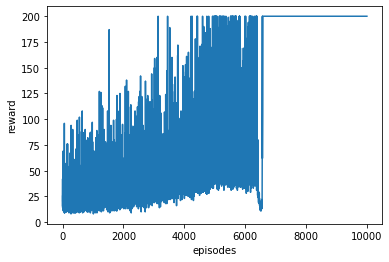

In [12]:
# plot average reward data
# print(rewards[:,:,:].shape)
import pandas as pd

# d = pd.Series(rewards[0,0,:])
plt.plot(rewards)
plt.xlabel('episodes')
plt.ylabel('reward')
# plt.plot(rewards[:,:])

print('average reward per episode= {}'.format(np.mean(rewards, axis=0)))

In [13]:
my_dict = {}
# my_dict["data"] = "Their model params\ntensor([[-0.0049,  0.4691,  0.0008, -0.2552],\n        [-0.4204, -0.3378, -0.1222,  0.3769],\n        [ 0.2397,  0.1964,  0.1816,  0.3778],\n        [ 0.4347,  0.1436, -0.1596,  0.4537],\n        [ 0.4348,  0.0355, -0.0083,  0.3024],\n        [ 0.2166,  0.1349,  0.1098,  0.1224],\n        [ 0.1775, -0.1645,  0.2105, -0.0397],\n        [-0.0754, -0.4345,  0.3258,  0.1700],\n        [-0.2496, -0.3918, -0.4072,  0.3070],\n        [ 0.4155, -0.3877, -0.4982,  0.3630],\n        [-0.2475,  0.3201,  0.1642, -0.3372],\n        [ 0.2409,  0.1367, -0.3578,  0.0781],\n        [-0.1473,  0.2909,  0.2483,  0.2926],\n        [ 0.4901,  0.2115, -0.2738, -0.1703],\n        [-0.0600,  0.2908,  0.4502,  0.4441],\n        [ 0.4434,  0.4149, -0.2595,  0.1586],\n        [ 0.3966,  0.1285, -0.2990,  0.1227],\n        [-0.4980, -0.1935, -0.4164, -0.1403],\n        [ 0.1850,  0.4681, -0.3764,  0.4686],\n        [ 0.1104,  0.2758,  0.1343,  0.4484],\n        [-0.3391, -0.1275, -0.4930,  0.2192],\n        [ 0.1430, -0.1227, -0.2408, -0.2525],\n        [-0.0177,  0.3471,  0.3640, -0.1564],\n        [-0.0805, -0.4666,  0.4643, -0.3790],\n        [ 0.0126, -0.1771,  0.0444,  0.0462],\n        [ 0.2060,  0.0925,  0.3172, -0.2507],\n        [-0.4180, -0.0289,  0.1603,  0.4187],\n        [ 0.4140,  0.1766, -0.0715,  0.2054],\n        [-0.1019, -0.1722, -0.4649,  0.0474],\n        [ 0.0336, -0.4134, -0.4997, -0.2138],\n        [-0.0089, -0.0535,  0.3089,  0.3632],\n        [ 0.4706, -0.1999, -0.3329, -0.1394],\n        [-0.2437,  0.0588, -0.4512, -0.4312],\n        [-0.3709,  0.3943,  0.3293,  0.3457],\n        [ 0.2464,  0.3609,  0.2065,  0.1736],\n        [ 0.2262, -0.4726,  0.1455,  0.1766],\n        [ 0.1093,  0.2545,  0.0765, -0.0834],\n        [ 0.4327,  0.0756, -0.3747,  0.3781],\n        [-0.0350, -0.4322,  0.4699,  0.4775],\n        [ 0.1317, -0.0425,  0.4230, -0.3786],\n        [ 0.3679, -0.4886, -0.2918, -0.2127],\n        [ 0.3491, -0.1311, -0.0226,  0.1095],\n        [ 0.0184, -0.3099,  0.1176,  0.1575],\n        [ 0.0322, -0.0294, -0.2927, -0.3065],\n        [-0.1197,  0.0516,  0.3122, -0.2274],\n        [-0.0270,  0.1684,  0.2447, -0.0240],\n        [-0.2449,  0.1924, -0.4391,  0.4411],\n        [ 0.3282, -0.0320,  0.3797,  0.3175],\n        [-0.0109,  0.0690, -0.2216,  0.2285],\n        [ 0.1793, -0.1409, -0.4187, -0.0879],\n        [-0.0542,  0.1776, -0.0465, -0.4142],\n        [-0.2198, -0.0282,  0.0586, -0.1978],\n        [ 0.4521, -0.1308,  0.4037, -0.3965],\n        [ 0.4480,  0.3013, -0.3900, -0.2043],\n        [ 0.3752, -0.2595,  0.1841, -0.4292],\n        [ 0.3758,  0.0451,  0.2408,  0.4024],\n        [-0.1107, -0.0551,  0.0391, -0.3562],\n        [-0.3748, -0.2884, -0.2934,  0.3486],\n        [-0.1138,  0.2532,  0.1133,  0.1165],\n        [-0.3540, -0.1052,  0.2960,  0.2832],\n        [-0.1219, -0.3756, -0.1850,  0.3641],\n        [-0.1459,  0.4960,  0.2193, -0.4555],\n        [-0.4368, -0.4323,  0.3171,  0.1576],\n        [-0.4617,  0.4231,  0.1655,  0.1769]])\nMy model params\ntensor([[ 0.3041,  0.2882, -0.2917,  0.4162],\n        [ 0.1855,  0.4892,  0.0079, -0.1485],\n        [ 0.2827, -0.1978,  0.0915,  0.1492],\n        [ 0.2694,  0.2406, -0.0709,  0.0753],\n        [ 0.1781, -0.0996, -0.4768, -0.0902],\n        [ 0.0527,  0.3042,  0.4053, -0.4673],\n        [-0.3728,  0.4554,  0.1156,  0.1509],\n        [-0.2538,  0.1942, -0.3371,  0.1100],\n        [-0.3160, -0.2490, -0.2002,  0.1645],\n        [-0.1380,  0.0902, -0.0432,  0.1049],\n        [-0.1543,  0.4901,  0.0083,  0.0152],\n        [ 0.1811, -0.4768,  0.0971,  0.1288],\n        [ 0.2728,  0.4485, -0.2000,  0.1215],\n        [ 0.1950, -0.4748,  0.2200,  0.2112],\n        [-0.2967, -0.2873, -0.3639,  0.4410],\n        [-0.1727, -0.3969, -0.0300,  0.4692],\n        [-0.3265, -0.0512,  0.3419, -0.2583],\n        [-0.0901, -0.2474, -0.0358, -0.0221],\n        [-0.2907,  0.2076, -0.2116,  0.4516],\n        [-0.4855, -0.2546, -0.3364, -0.3318],\n        [-0.3998, -0.0230, -0.2552, -0.2768],\n        [-0.3959,  0.0057,  0.4193,  0.2657],\n        [-0.1441,  0.2253,  0.4854, -0.1122],\n        [-0.1419,  0.1340, -0.2012,  0.2925],\n        [ 0.3803,  0.3698, -0.4950, -0.1462],\n        [-0.1645, -0.4683,  0.1710, -0.0956],\n        [ 0.0400,  0.0339,  0.3003,  0.3645],\n        [ 0.4606, -0.0104, -0.0227,  0.3237],\n        [ 0.4904,  0.4335, -0.2649,  0.2615],\n        [ 0.1789, -0.3907, -0.1692, -0.2415],\n        [ 0.2577,  0.3993,  0.3816, -0.0371],\n        [-0.0268,  0.4042,  0.2384,  0.4170],\n        [ 0.3716, -0.1569, -0.2289, -0.4692],\n        [-0.3748, -0.0156, -0.1977,  0.2151],\n        [ 0.1638,  0.2755,  0.2921, -0.4573],\n        [ 0.3901, -0.0634, -0.2933, -0.1968],\n        [ 0.4970, -0.1262,  0.3650,  0.4007],\n        [ 0.2788,  0.1445,  0.0942,  0.1048],\n        [-0.3838, -0.4978, -0.4175, -0.1444],\n        [-0.2990,  0.0109,  0.2287,  0.1491],\n        [-0.2714,  0.1556, -0.0731,  0.4427],\n        [-0.4720, -0.1670, -0.1322,  0.4997],\n        [-0.0374, -0.2431, -0.4579, -0.1824],\n        [ 0.2399, -0.1023, -0.0905, -0.0190],\n        [-0.1580,  0.1126, -0.1087, -0.4724],\n        [-0.0587, -0.2401,  0.3096,  0.0515],\n        [-0.1888,  0.1881, -0.2436, -0.3915],\n        [-0.0538, -0.3004,  0.4868,  0.4518],\n        [ 0.4151,  0.3819, -0.4865, -0.2404],\n        [-0.4273,  0.0289, -0.3914, -0.1450],\n        [ 0.4119,  0.4608, -0.0953, -0.2822],\n        [-0.2009, -0.2225,  0.3750,  0.1481],\n        [ 0.4009,  0.2628, -0.4354,  0.4003],\n        [ 0.1444,  0.0308,  0.4046,  0.0810],\n        [ 0.0310,  0.0230, -0.3415, -0.2876],\n        [ 0.0175, -0.4231, -0.2572, -0.4341],\n        [ 0.1194, -0.0733, -0.1846,  0.3522],\n        [-0.2700, -0.0280,  0.4058,  0.1455],\n        [-0.1910, -0.2753, -0.4003, -0.1842],\n        [-0.2268, -0.4600, -0.1236, -0.1261],\n        [-0.3728, -0.3369,  0.4468,  0.1672],\n        [ 0.4776, -0.4104,  0.1595,  0.0460],\n        [-0.1318,  0.4914, -0.4923,  0.3753],\n        [ 0.2644, -0.2238,  0.1891,  0.0529]])\ntheir model = Sequential(\n  (0): Linear(in_features=4, out_features=64, bias=True)\n  (1): Tanh()\n  (2): Linear(in_features=64, out_features=2, bias=True)\n  (3): Identity()\n)\n"
# "Their model params\ntensor([[-0.0049,  0.4691,  0.0008, -0.2552],\n        [-0.4204, -0.3378, -0.1222,  0.3769],\n        [ 0.2397,  0.1964,  0.1816,  0.3778],\n        [ 0.4347,  0.1436, -0.1596,  0.4537],\n        [ 0.4348,  0.0355, -0.0083,  0.3024],\n        [ 0.2166,  0.1349,  0.1098,  0.1224],\n        [ 0.1775, -0.1645,  0.2105, -0.0397],\n        [-0.0754, -0.4345,  0.3258,  0.1700],\n        [-0.2496, -0.3918, -0.4072,  0.3070],\n        [ 0.4155, -0.3877, -0.4982,  0.3630],\n        [-0.2475,  0.3201,  0.1642, -0.3372],\n        [ 0.2409,  0.1367, -0.3578,  0.0781],\n        [-0.1473,  0.2909,  0.2483,  0.2926],\n        [ 0.4901,  0.2115, -0.2738, -0.1703],\n        [-0.0600,  0.2908,  0.4502,  0.4441],\n        [ 0.4434,  0.4149, -0.2595,  0.1586],\n        [ 0.3966,  0.1285, -0.2990,  0.1227],\n        [-0.4980, -0.1935, -0.4164, -0.1403],\n        [ 0.1850,  0.4681, -0.3764,  0.4686],\n        [ 0.1104,  0.2758,  0.1343,  0.4484],\n        [-0.3391, -0.1275, -0.4930,  0.2192],\n        [ 0.1430, -0.1227, -0.2408, -0.2525],\n        [-0.0177,  0.3471,  0.3640, -0.1564],\n        [-0.0805, -0.4666,  0.4643, -0.3790],\n        [ 0.0126, -0.1771,  0.0444,  0.0462],\n        [ 0.2060,  0.0925,  0.3172, -0.2507],\n        [-0.4180, -0.0289,  0.1603,  0.4187],\n        [ 0.4140,  0.1766, -0.0715,  0.2054],\n        [-0.1019, -0.1722, -0.4649,  0.0474],\n        [ 0.0336, -0.4134, -0.4997, -0.2138],\n        [-0.0089, -0.0535,  0.3089,  0.3632],\n        [ 0.4706, -0.1999, -0.3329, -0.1394],\n        [-0.2437,  0.0588, -0.4512, -0.4312],\n        [-0.3709,  0.3943,  0.3293,  0.3457],\n        [ 0.2464,  0.3609,  0.2065,  0.1736],\n        [ 0.2262, -0.4726,  0.1455,  0.1766],\n        [ 0.1093,  0.2545,  0.0765, -0.0834],\n        [ 0.4327,  0.0756, -0.3747,  0.3781],\n        [-0.0350, -0.4322,  0.4699,  0.4775],\n        [ 0.1317, -0.0425,  0.4230, -0.3786],\n        [ 0.3679, -0.4886, -0.2918, -0.2127],\n        [ 0.3491, -0.1311, -0.0226,  0.1095],\n        [ 0.0184, -0.3099,  0.1176,  0.1575],\n        [ 0.0322, -0.0294, -0.2927, -0.3065],\n        [-0.1197,  0.0516,  0.3122, -0.2274],\n        [-0.0270,  0.1684,  0.2447, -0.0240],\n        [-0.2449,  0.1924, -0.4391,  0.4411],\n        [ 0.3282, -0.0320,  0.3797,  0.3175],\n        [-0.0109,  0.0690, -0.2216,  0.2285],\n        [ 0.1793, -0.1409, -0.4187, -0.0879],\n        [-0.0542,  0.1776, -0.0465, -0.4142],\n        [-0.2198, -0.0282,  0.0586, -0.1978],\n        [ 0.4521, -0.1308,  0.4037, -0.3965],\n        [ 0.4480,  0.3013, -0.3900, -0.2043],\n        [ 0.3752, -0.2595,  0.1841, -0.4292],\n        [ 0.3758,  0.0451,  0.2408,  0.4024],\n        [-0.1107, -0.0551,  0.0391, -0.3562],\n        [-0.3748, -0.2884, -0.2934,  0.3486],\n        [-0.1138,  0.2532,  0.1133,  0.1165],\n        [-0.3540, -0.1052,  0.2960,  0.2832],\n        [-0.1219, -0.3756, -0.1850,  0.3641],\n        [-0.1459,  0.4960,  0.2193, -0.4555],\n        [-0.4368, -0.4323,  0.3171,  0.1576],\n        [-0.4617,  0.4231,  0.1655,  0.1769]])\nMy model params\ntensor([[-0.0049,  0.4691,  0.0008, -0.2552],\n        [-0.4204, -0.3378, -0.1222,  0.3769],\n        [ 0.2397,  0.1964,  0.1816,  0.3778],\n        [ 0.4347,  0.1436, -0.1596,  0.4537],\n        [ 0.4348,  0.0355, -0.0083,  0.3024],\n        [ 0.2166,  0.1349,  0.1098,  0.1224],\n        [ 0.1775, -0.1645,  0.2105, -0.0397],\n        [-0.0754, -0.4345,  0.3258,  0.1700],\n        [-0.2496, -0.3918, -0.4072,  0.3070],\n        [ 0.4155, -0.3877, -0.4982,  0.3630],\n        [-0.2475,  0.3201,  0.1642, -0.3372],\n        [ 0.2409,  0.1367, -0.3578,  0.0781],\n        [-0.1473,  0.2909,  0.2483,  0.2926],\n        [ 0.4901,  0.2115, -0.2738, -0.1703],\n        [-0.0600,  0.2908,  0.4502,  0.4441],\n        [ 0.4434,  0.4149, -0.2595,  0.1586],\n        [ 0.3966,  0.1285, -0.2990,  0.1227],\n        [-0.4980, -0.1935, -0.4164, -0.1403],\n        [ 0.1850,  0.4681, -0.3764,  0.4686],\n        [ 0.1104,  0.2758,  0.1343,  0.4484],\n        [-0.3391, -0.1275, -0.4930,  0.2192],\n        [ 0.1430, -0.1227, -0.2408, -0.2525],\n        [-0.0177,  0.3471,  0.3640, -0.1564],\n        [-0.0805, -0.4666,  0.4643, -0.3790],\n        [ 0.0126, -0.1771,  0.0444,  0.0462],\n        [ 0.2060,  0.0925,  0.3172, -0.2507],\n        [-0.4180, -0.0289,  0.1603,  0.4187],\n        [ 0.4140,  0.1766, -0.0715,  0.2054],\n        [-0.1019, -0.1722, -0.4649,  0.0474],\n        [ 0.0336, -0.4134, -0.4997, -0.2138],\n        [-0.0089, -0.0535,  0.3089,  0.3632],\n        [ 0.4706, -0.1999, -0.3329, -0.1394],\n        [-0.2437,  0.0588, -0.4512, -0.4312],\n        [-0.3709,  0.3943,  0.3293,  0.3457],\n        [ 0.2464,  0.3609,  0.2065,  0.1736],\n        [ 0.2262, -0.4726,  0.1455,  0.1766],\n        [ 0.1093,  0.2545,  0.0765, -0.0834],\n        [ 0.4327,  0.0756, -0.3747,  0.3781],\n        [-0.0350, -0.4322,  0.4699,  0.4775],\n        [ 0.1317, -0.0425,  0.4230, -0.3786],\n        [ 0.3679, -0.4886, -0.2918, -0.2127],\n        [ 0.3491, -0.1311, -0.0226,  0.1095],\n        [ 0.0184, -0.3099,  0.1176,  0.1575],\n        [ 0.0322, -0.0294, -0.2927, -0.3065],\n        [-0.1197,  0.0516,  0.3122, -0.2274],\n        [-0.0270,  0.1684,  0.2447, -0.0240],\n        [-0.2449,  0.1924, -0.4391,  0.4411],\n        [ 0.3282, -0.0320,  0.3797,  0.3175],\n        [-0.0109,  0.0690, -0.2216,  0.2285],\n        [ 0.1793, -0.1409, -0.4187, -0.0879],\n        [-0.0542,  0.1776, -0.0465, -0.4142],\n        [-0.2198, -0.0282,  0.0586, -0.1978],\n        [ 0.4521, -0.1308,  0.4037, -0.3965],\n        [ 0.4480,  0.3013, -0.3900, -0.2043],\n        [ 0.3752, -0.2595,  0.1841, -0.4292],\n        [ 0.3758,  0.0451,  0.2408,  0.4024],\n        [-0.1107, -0.0551,  0.0391, -0.3562],\n        [-0.3748, -0.2884, -0.2934,  0.3486],\n        [-0.1138,  0.2532,  0.1133,  0.1165],\n        [-0.3540, -0.1052,  0.2960,  0.2832],\n        [-0.1219, -0.3756, -0.1850,  0.3641],\n        [-0.1459,  0.4960,  0.2193, -0.4555],\n        [-0.4368, -0.4323,  0.3171,  0.1576],\n        [-0.4617,  0.4231,  0.1655,  0.1769]])\n"
my_dict["data"] = "Their model params\ntensor([[-0.0049,  0.4691,  0.0008, -0.2552],\n        [-0.4204, -0.3378, -0.1222,  0.3769],\n        [ 0.2397,  0.1964,  0.1816,  0.3778],\n        [ 0.4347,  0.1436, -0.1596,  0.4537],\n        [ 0.4348,  0.0355, -0.0083,  0.3024],\n        [ 0.2166,  0.1349,  0.1098,  0.1224],\n        [ 0.1775, -0.1645,  0.2105, -0.0397],\n        [-0.0754, -0.4345,  0.3258,  0.1700],\n        [-0.2496, -0.3918, -0.4072,  0.3070],\n        [ 0.4155, -0.3877, -0.4982,  0.3630],\n        [-0.2475,  0.3201,  0.1642, -0.3372],\n        [ 0.2409,  0.1367, -0.3578,  0.0781],\n        [-0.1473,  0.2909,  0.2483,  0.2926],\n        [ 0.4901,  0.2115, -0.2738, -0.1703],\n        [-0.0600,  0.2908,  0.4502,  0.4441],\n        [ 0.4434,  0.4149, -0.2595,  0.1586],\n        [ 0.3966,  0.1285, -0.2990,  0.1227],\n        [-0.4980, -0.1935, -0.4164, -0.1403],\n        [ 0.1850,  0.4681, -0.3764,  0.4686],\n        [ 0.1104,  0.2758,  0.1343,  0.4484],\n        [-0.3391, -0.1275, -0.4930,  0.2192],\n        [ 0.1430, -0.1227, -0.2408, -0.2525],\n        [-0.0177,  0.3471,  0.3640, -0.1564],\n        [-0.0805, -0.4666,  0.4643, -0.3790],\n        [ 0.0126, -0.1771,  0.0444,  0.0462],\n        [ 0.2060,  0.0925,  0.3172, -0.2507],\n        [-0.4180, -0.0289,  0.1603,  0.4187],\n        [ 0.4140,  0.1766, -0.0715,  0.2054],\n        [-0.1019, -0.1722, -0.4649,  0.0474],\n        [ 0.0336, -0.4134, -0.4997, -0.2138],\n        [-0.0089, -0.0535,  0.3089,  0.3632],\n        [ 0.4706, -0.1999, -0.3329, -0.1394],\n        [-0.2437,  0.0588, -0.4512, -0.4312],\n        [-0.3709,  0.3943,  0.3293,  0.3457],\n        [ 0.2464,  0.3609,  0.2065,  0.1736],\n        [ 0.2262, -0.4726,  0.1455,  0.1766],\n        [ 0.1093,  0.2545,  0.0765, -0.0834],\n        [ 0.4327,  0.0756, -0.3747,  0.3781],\n        [-0.0350, -0.4322,  0.4699,  0.4775],\n        [ 0.1317, -0.0425,  0.4230, -0.3786],\n        [ 0.3679, -0.4886, -0.2918, -0.2127],\n        [ 0.3491, -0.1311, -0.0226,  0.1095],\n        [ 0.0184, -0.3099,  0.1176,  0.1575],\n        [ 0.0322, -0.0294, -0.2927, -0.3065],\n        [-0.1197,  0.0516,  0.3122, -0.2274],\n        [-0.0270,  0.1684,  0.2447, -0.0240],\n        [-0.2449,  0.1924, -0.4391,  0.4411],\n        [ 0.3282, -0.0320,  0.3797,  0.3175],\n        [-0.0109,  0.0690, -0.2216,  0.2285],\n        [ 0.1793, -0.1409, -0.4187, -0.0879],\n        [-0.0542,  0.1776, -0.0465, -0.4142],\n        [-0.2198, -0.0282,  0.0586, -0.1978],\n        [ 0.4521, -0.1308,  0.4037, -0.3965],\n        [ 0.4480,  0.3013, -0.3900, -0.2043],\n        [ 0.3752, -0.2595,  0.1841, -0.4292],\n        [ 0.3758,  0.0451,  0.2408,  0.4024],\n        [-0.1107, -0.0551,  0.0391, -0.3562],\n        [-0.3748, -0.2884, -0.2934,  0.3486],\n        [-0.1138,  0.2532,  0.1133,  0.1165],\n        [-0.3540, -0.1052,  0.2960,  0.2832],\n        [-0.1219, -0.3756, -0.1850,  0.3641],\n        [-0.1459,  0.4960,  0.2193, -0.4555],\n        [-0.4368, -0.4323,  0.3171,  0.1576],\n        [-0.4617,  0.4231,  0.1655,  0.1769]])\nMy model params\ntensor([[-0.0049,  0.4691,  0.0008, -0.2552],\n        [-0.4204, -0.3378, -0.1222,  0.3769],\n        [ 0.2397,  0.1964,  0.1816,  0.3778],\n        [ 0.4347,  0.1436, -0.1596,  0.4537],\n        [ 0.4348,  0.0355, -0.0083,  0.3024],\n        [ 0.2166,  0.1349,  0.1098,  0.1224],\n        [ 0.1775, -0.1645,  0.2105, -0.0397],\n        [-0.0754, -0.4345,  0.3258,  0.1700],\n        [-0.2496, -0.3918, -0.4072,  0.3070],\n        [ 0.4155, -0.3877, -0.4982,  0.3630],\n        [-0.2475,  0.3201,  0.1642, -0.3372],\n        [ 0.2409,  0.1367, -0.3578,  0.0781],\n        [-0.1473,  0.2909,  0.2483,  0.2926],\n        [ 0.4901,  0.2115, -0.2738, -0.1703],\n        [-0.0600,  0.2908,  0.4502,  0.4441],\n        [ 0.4434,  0.4149, -0.2595,  0.1586],\n        [ 0.3966,  0.1285, -0.2990,  0.1227],\n        [-0.4980, -0.1935, -0.4164, -0.1403],\n        [ 0.1850,  0.4681, -0.3764,  0.4686],\n        [ 0.1104,  0.2758,  0.1343,  0.4484],\n        [-0.3391, -0.1275, -0.4930,  0.2192],\n        [ 0.1430, -0.1227, -0.2408, -0.2525],\n        [-0.0177,  0.3471,  0.3640, -0.1564],\n        [-0.0805, -0.4666,  0.4643, -0.3790],\n        [ 0.0126, -0.1771,  0.0444,  0.0462],\n        [ 0.2060,  0.0925,  0.3172, -0.2507],\n        [-0.4180, -0.0289,  0.1603,  0.4187],\n        [ 0.4140,  0.1766, -0.0715,  0.2054],\n        [-0.1019, -0.1722, -0.4649,  0.0474],\n        [ 0.0336, -0.4134, -0.4997, -0.2138],\n        [-0.0089, -0.0535,  0.3089,  0.3632],\n        [ 0.4706, -0.1999, -0.3329, -0.1394],\n        [-0.2437,  0.0588, -0.4512, -0.4312],\n        [-0.3709,  0.3943,  0.3293,  0.3457],\n        [ 0.2464,  0.3609,  0.2065,  0.1736],\n        [ 0.2262, -0.4726,  0.1455,  0.1766],\n        [ 0.1093,  0.2545,  0.0765, -0.0834],\n        [ 0.4327,  0.0756, -0.3747,  0.3781],\n        [-0.0350, -0.4322,  0.4699,  0.4775],\n        [ 0.1317, -0.0425,  0.4230, -0.3786],\n        [ 0.3679, -0.4886, -0.2918, -0.2127],\n        [ 0.3491, -0.1311, -0.0226,  0.1095],\n        [ 0.0184, -0.3099,  0.1176,  0.1575],\n        [ 0.0322, -0.0294, -0.2927, -0.3065],\n        [-0.1197,  0.0516,  0.3122, -0.2274],\n        [-0.0270,  0.1684,  0.2447, -0.0240],\n        [-0.2449,  0.1924, -0.4391,  0.4411],\n        [ 0.3282, -0.0320,  0.3797,  0.3175],\n        [-0.0109,  0.0690, -0.2216,  0.2285],\n        [ 0.1793, -0.1409, -0.4187, -0.0879],\n        [-0.0542,  0.1776, -0.0465, -0.4142],\n        [-0.2198, -0.0282,  0.0586, -0.1978],\n        [ 0.4521, -0.1308,  0.4037, -0.3965],\n        [ 0.4480,  0.3013, -0.3900, -0.2043],\n        [ 0.3752, -0.2595,  0.1841, -0.4292],\n        [ 0.3758,  0.0451,  0.2408,  0.4024],\n        [-0.1107, -0.0551,  0.0391, -0.3562],\n        [-0.3748, -0.2884, -0.2934,  0.3486],\n        [-0.1138,  0.2532,  0.1133,  0.1165],\n        [-0.3540, -0.1052,  0.2960,  0.2832],\n        [-0.1219, -0.3756, -0.1850,  0.3641],\n        [-0.1459,  0.4960,  0.2193, -0.4555],\n        [-0.4368, -0.4323,  0.3171,  0.1576],\n        [-0.4617,  0.4231,  0.1655,  0.1769]])\n"

print(my_dict["data"])

Their model params
tensor([[-0.0049,  0.4691,  0.0008, -0.2552],
        [-0.4204, -0.3378, -0.1222,  0.3769],
        [ 0.2397,  0.1964,  0.1816,  0.3778],
        [ 0.4347,  0.1436, -0.1596,  0.4537],
        [ 0.4348,  0.0355, -0.0083,  0.3024],
        [ 0.2166,  0.1349,  0.1098,  0.1224],
        [ 0.1775, -0.1645,  0.2105, -0.0397],
        [-0.0754, -0.4345,  0.3258,  0.1700],
        [-0.2496, -0.3918, -0.4072,  0.3070],
        [ 0.4155, -0.3877, -0.4982,  0.3630],
        [-0.2475,  0.3201,  0.1642, -0.3372],
        [ 0.2409,  0.1367, -0.3578,  0.0781],
        [-0.1473,  0.2909,  0.2483,  0.2926],
        [ 0.4901,  0.2115, -0.2738, -0.1703],
        [-0.0600,  0.2908,  0.4502,  0.4441],
        [ 0.4434,  0.4149, -0.2595,  0.1586],
        [ 0.3966,  0.1285, -0.2990,  0.1227],
        [-0.4980, -0.1935, -0.4164, -0.1403],
        [ 0.1850,  0.4681, -0.3764,  0.4686],
        [ 0.1104,  0.2758,  0.1343,  0.4484],
        [-0.3391, -0.1275, -0.4930,  0.2192],
        [ 0.143

In [14]:
# for param in q_approx.parameters():
#     print(param.size())

In [15]:
# RENDER = False
# total_rewards = []
# for episode in range(EPISODES):
#     done = False
#     obs = agent.env.reset()
#     obs = torch.tensor([obs], device=agent.device, dtype=torch.float64)
#     rewards = []
#     while not done:
#         # get action to execute based on state
#         action = agent.get_action(obs.float())
#         #  take action, go to next time step
#         obs_next, reward, done, info = agent.env.step(action.item())
#         obs_next = torch.tensor([obs_next], device=agent.device, dtype=torch.float64)
#         obs = obs_next
#         rewards.append(reward)
#         if RENDER:
#             env.render()

#     rewards = np.array(rewards)
#     total_rewards.append(np.sum(rewards))

# plt.plot(total_rewards)
# plt.show()

In [16]:
'''

learning_rate = 0.0001
EPSILON_MIN = 0.05
EPS_DECAY = 0.001
gamma= 0.99
TARGET_UPDATE = 10
EPISODES = 10000

MEMORY_SIZE = 256
D = deque(maxlen=MEMORY_SIZE)
MINI_BATCH_SIZE = 16
epsilon=1



q_approx = DQN(lr=learning_rate, device=device).to(device)
q_target = DQN(lr=learning_rate, device=device).to(device)
# load same weights as approx
q_target.load_state_dict(q_approx.state_dict())
q_target.eval()
# reset replay memory
D = deque(maxlen=MEMORY_SIZE)
agent = Agent(q_approx, q_target, env, epsilon, gamma, MINI_BATCH_SIZE)
for episode in range(EPISODES):

    if episode % 1000 == 0:
        print('-'*5)
        print('Episode = {}'.format(episode))
        print('Epsilon = {}'.format(agent.epsilon))
        print('-'*5)
    # train one episode
    agent.train_episode()

    # update epsilon value
    # agent.epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN)*np.exp(-EPS_DECAY*episode)
    if agent.epsilon > 0.05 :
        agent.epsilon -= (1 / 5000)

    # # update target paramters
    if episode % TARGET_UPDATE == 0:
        q_target.load_state_dict(q_approx.state_dict())
        q_target.eval()

# shallow copy
# rewards_per_episode = agent.train_data.copy()
# alias
rewards_per_episode = agent.train_data

total_rewards = np.sum(rewards_per_episode)
print("Score over time: {}, gamma={}".format( total_rewards/EPISODES, gamma))
average_reward = total_rewards/EPISODES

plt.plot(rewards_per_episode)


'''

'\n\nlearning_rate = 0.0001\nEPSILON_MIN = 0.05\nEPS_DECAY = 0.001\ngamma= 0.99\nTARGET_UPDATE = 10\nEPISODES = 10000\n\nMEMORY_SIZE = 256\nD = deque(maxlen=MEMORY_SIZE)\nMINI_BATCH_SIZE = 16\nepsilon=1\n\n\n\nq_approx = DQN(lr=learning_rate, device=device).to(device)\nq_target = DQN(lr=learning_rate, device=device).to(device)\n# load same weights as approx\nq_target.load_state_dict(q_approx.state_dict())\nq_target.eval()\n# reset replay memory\nD = deque(maxlen=MEMORY_SIZE)\nagent = Agent(q_approx, q_target, env, epsilon, gamma, MINI_BATCH_SIZE)\nfor episode in range(EPISODES):\n\n    if episode % 1000 == 0:\n        print(\'-\'*5)\n        print(\'Episode = {}\'.format(episode))\n        print(\'Epsilon = {}\'.format(agent.epsilon))\n        print(\'-\'*5)\n    # train one episode\n    agent.train_episode()\n\n    # update epsilon value\n    # agent.epsilon = EPSILON_MIN + (EPSILON_START - EPSILON_MIN)*np.exp(-EPS_DECAY*episode)\n    if agent.epsilon > 0.05 :\n        agent.epsilon -